# Part 4: Testing the RoBERTa-LSTM Model

In the following notebook, we will use the weights of the model we trained on the Yelp Dataset and use it on our test dataset.

## Installing Dependencies

In [1]:
! pip install -q gdown
! pip install -q transformers

## Downloading Dataset and Model Weights

In [2]:
file_ids = [
    '1fh27qYFov1hvPCQkPkBUJrw6PfmF2M5o',
    '17A_cbIZP53Ho9itsF8Sz43IScLssin_U',
    '1j4JnzhLushqU-AFd1KOn08_Kt_YC77YN'
]

In [3]:
for file_id in file_ids:
    ! gdown {file_id}

Downloading...
From (original): https://drive.google.com/uc?id=1fh27qYFov1hvPCQkPkBUJrw6PfmF2M5o
From (redirected): https://drive.google.com/uc?id=1fh27qYFov1hvPCQkPkBUJrw6PfmF2M5o&confirm=t&uuid=69596c9f-ec0a-41e4-a9ab-a7418daa8f2a
To: /kaggle/working/best_model.pt
100%|████████████████████████████████████████| 507M/507M [00:05<00:00, 98.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=17A_cbIZP53Ho9itsF8Sz43IScLssin_U
To: /kaggle/working/test_labels.pt
100%|███████████████████████████████████████| 1.20M/1.20M [00:00<00:00, 106MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1j4JnzhLushqU-AFd1KOn08_Kt_YC77YN
From (redirected): https://drive.google.com/uc?id=1j4JnzhLushqU-AFd1KOn08_Kt_YC77YN&confirm=t&uuid=2942af1e-e182-48aa-9c45-6be9295ed85f
To: /kaggle/working/test_encodings.pt
100%|█████████████████████████████████████████| 614M/614M [00:04<00:00, 153MB/s]


## Importing Dependencies

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel
from torch.nn import DataParallel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sn

## Loading Weights and Model Initialization

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
test_encodings = torch.load("test_encodings.pt")
test_labels = torch.load("test_labels.pt")

In [7]:
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
test_loader = DataLoader(test_dataset, batch_size=512, pin_memory=True)

In [8]:
class RoBERTa_LSTM(nn.Module):
    def __init__(self, roberta_model='roberta-base', lstm_hidden=256, num_classes=3):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(roberta_model)
        self.lstm = nn.LSTM(input_size=self.roberta.config.hidden_size,
                            hidden_size=lstm_hidden,
                            batch_first=True,
                            bidirectional=True)
        self.norm = nn.LayerNorm(lstm_hidden * 2)
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        roberta_out = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.lstm(roberta_out)
        pooled = torch.mean(lstm_out, dim=1)
        normed = self.norm(pooled)
        return self.fc(self.drop(normed))

## Testing

In [9]:
model = RoBERTa_LSTM()
model = DataParallel(model)
model.module.load_state_dict(torch.load("best_model.pt"))
model = model.to(device)
model.eval()

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

2025-07-08 11:37:38.101032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751974658.317668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751974658.378214      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): RoBERTa_LSTM(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_featur

In [10]:
all_preds = []
all_targets = []

In [11]:
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

Evaluating:   0%|          | 0/293 [00:00<?, ?it/s]

## Results

In [12]:
print("Test Accuracy:", accuracy_score(all_targets, all_preds))
print("Classification Report:\n", classification_report(all_targets, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))

Test Accuracy: 0.8602241643872173
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     49955
           1       0.78      0.81      0.80     49948
           2       0.92      0.90      0.91     49987

    accuracy                           0.86    149890
   macro avg       0.86      0.86      0.86    149890
weighted avg       0.86      0.86      0.86    149890

Confusion Matrix:
 [[43437  6382   136]
 [ 5503 40426  4019]
 [  146  4765 45076]]


In [17]:
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')
cm = confusion_matrix(all_targets, all_preds)
labels = sorted(list(set(all_targets)))

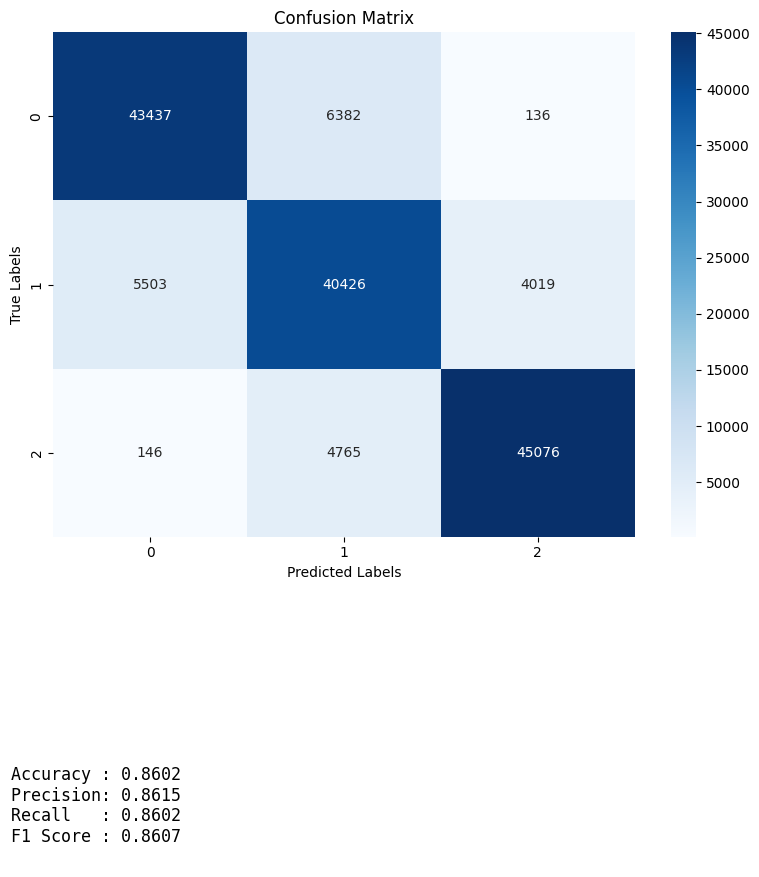

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

metrics_text = f"""
Accuracy : {accuracy:.4f}
Precision: {precision:.4f}
Recall   : {recall:.4f}
F1 Score : {f1:.4f}
"""
plt.gcf().text(0.02, -0.25, metrics_text, fontsize=12, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()
